# Fourier Transforms For Mechanical Applications

Not required for MECH 217, but interesting.

We are almost always interested in finding the frequency content of a time series of regularly sampled, real data. Fast Fourier Transform (FFT) algorithms are optimized for speed in calculating transforms for series of n samples when n is a power of 2 (64, 128, 256, etc.). Discrete or Finite Fourier Transform (FFT) algorithms can be generalized to let you calculate the transform for any number of samples. 

https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.fft.html

Import the usual collection of libraries

In [1]:
# gets all of numpy but you will still need to refer to e.g. numpy.random.randn() as random.randn()
from numpy import *               # all of the array capable elements for numerical data          
from scipy.stats import norm      # comprehensive functions for Gaussian normal distributions
import csv                        # library for reading and writing comma separated value files
from matplotlib.pyplot import *   # all of pyplot to graph the results of our calculations

# put figures inline in the notebook, so you don't have to call show()
%matplotlib inline

# This lets you make the default figure size larger (or smaller)
from IPython.core.pylabtools import figsize
#figsize(14, 7)

## Create some data to analyze

Usually this would be data you had measured somewhere that you wanted to find the frequency characteristics -- for example, vibration in a rotating piece of equipment.

The faster you sample the data, the higher the frequency you can resolve. The highest frequency in the FFT results will be the Nyquist Frequency $2/\Delta t$ where  $\Delta t$ is the time between the samples.

The more samples you take, the better the frequency resolution. The frquency range will include 0, the mean or DC component plus n/2 bins representing finite frequency ranges evenly spaced up to the Nyquist Frequency.

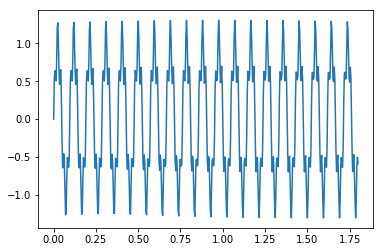

In [2]:
# Traditionally we use powers of for number of samples in FFT for speed.
n = 512                # the number of samples in the time series
P = 1.8                 # the total sampling time
f1 = 10.5               # dominant frequency Hz
t = linspace(0,P,n)   # a time scale with n points
dt = P/(n-1)              # the time step
a = sin(t*f1*2.0*pi)        # a real signal
a += 0.3 * sin(t*f1*10*pi)  # 5 times higher f, lower amplitude 
a += 0.03 * sin(t*f1*20*pi) # 10 times higher f, even lower amplitude
plot(t,a)

In [3]:
z = fft.fft(a)        # an fft returns a complex result, even for a real input
print(z[:5])

[ 0.98114084+0.j          0.98211210+0.09099952j  0.98505743+0.18348765j
  0.99007420+0.27903806j  0.99733414+0.37940499j]


In [4]:
f = fft.fftfreq(n,dt) # the frequencies corresponding to each bin go from 0 to 1/(2dt)
print(f[:5])
print(f[int(n/2)-2:int(n/2)+3])
print(f[n-5:])

[ 0.          0.55447049  1.10894097  1.66341146  2.21788194]
[ 140.83550347  141.38997396 -141.94444444 -141.38997396 -140.83550347]
[-2.77235243 -2.21788194 -1.66341146 -1.10894097 -0.55447049]


## Complex Output
The complex output has n real and n imaginary components resulting from fitting n sine and cosine waves to the n real and n imaginary inputs. We are often only interested in the frequency information, so we calculate a combined power spectrum from the sum of the squares of all the components at a particular frequency.

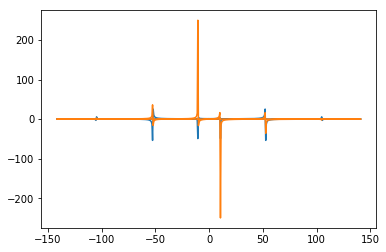

In [5]:
plot(f,z.real)
plot(f,z.imag)

## Power Spectral Density

Combining the sums of the squares for all components at a particular frequency gives the power at that frequency and normalizing it to integrate to unity over the frequency range makes it a power spectral density. It is commonly plotted as a semilog plot, so you can see the structure at all the magnitude levels. Notice how the third peak is invisible in the first plot.

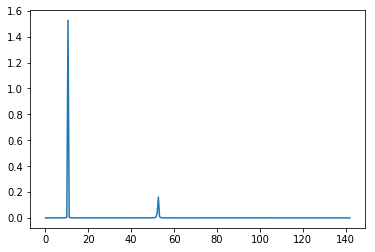

In [6]:
def psd(a,dt):
    powerIn = mean(a**2)*len(a)*dt       # total power input in the signal
    n = len(a)
    np = int((n+2)/2)
    z = fft.fft(a)
    f = fft.fftfreq(n,dt)
    fp = abs(f[:np])
    p = z[:np].real**2+z.imag[:np]**2    # the front half of the transform
    intp = 0
    for i in range(1,int((n-1)/2)):      # the back half of the transform
        p[i] += z[n-i].real**2 + z[n-1].imag**2
        p[i] /= 2
        intp += (p[i]+p[i-1])/2*(fp[i]-fp[i-1])
    return (fp,p/intp*powerIn)                   # normalize for an integral of powerIn

fp,p = psd(a,dt)
plot(fp,p)

(1e-06, 10.0)

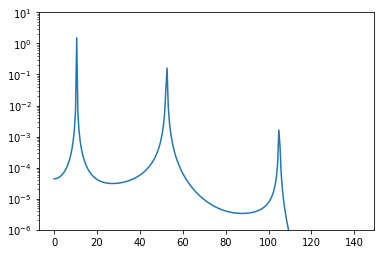

In [7]:
semilogy(fp,p)
ylim(1e-6,1e1)

## Periodograms

This functionality is needed so often that there's a whole family of functions for estimating power spectral density "periodograms" with different types of scaling and approximations. Using one of these functions can be way faster than looking after the details for yourself.

https://docs.scipy.org/doc/scipy-0.16.1/reference/signal.html

(1e-06, 10.0)

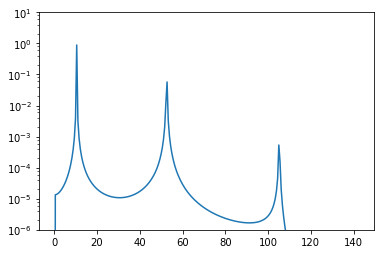

In [231]:
from scipy.signal import periodogram
fpp,pp = periodogram(a,1/dt)
semilogy(fpp,pp)
ylim(1e-6,1e1)

## Noise shows at all frequencies
The higher frequency components are no longer visible in the signal, but the larger one is still detectable as a peak in the power spectrum.

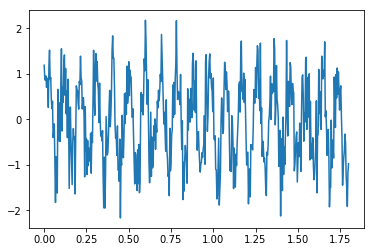

In [232]:
b = a + random.randn(len(a))*0.5
plot(t,b)


(1e-06, 10.0)

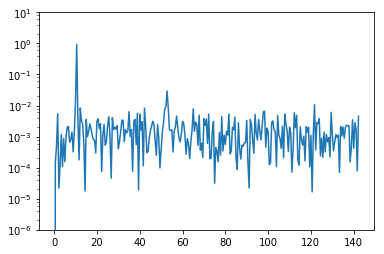

In [233]:
fppp,ppp = periodogram(b,1/dt)
semilogy(fppp,ppp)
ylim(1e-6,1e1)

## FFT for Load Cell Data
Plotting the PSD on log-log scales makes it easier to pick out the dominant peaks at low frequencies from this load cell transient test data.

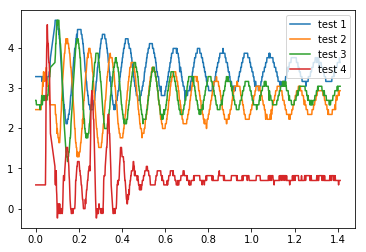

In [234]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import numpy as np

with open('Load Cell Data to Share.csv') as csvfile:
    dataRead = csv.reader(csvfile)
    a = np.asarray([data for data in dataRead])
#print(a[0:5])
d = np.asfarray(a[1:,1:len(a[1])-1])
#print(d[0:5])
tt = d[:,0]/1000
plt.plot(tt,d[:,1], label = 'test 1')
plt.plot(tt,d[:,2], label = 'test 2')
plt.plot(tt,d[:,3], label = 'test 3')
plt.plot(tt,d[:,4], label = 'test 4')
plt.legend()

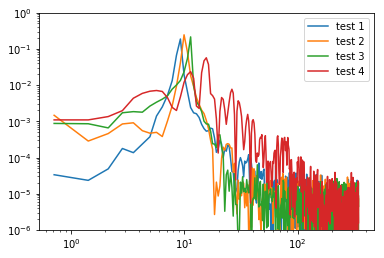

In [235]:
for i in range(1,5):
    fppp,ppp = periodogram(d[:,i],1/(tt[5]-tt[4]))
    loglog(fppp,ppp,label = 'test %d'%i)
ylim(1e-6,1e0)
legend()

(0.0001, 100.0)

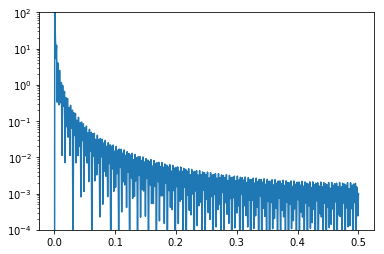

In [236]:
c = zeros(1000)
c[387:]=1
fpppp,pppp = periodogram(c)
semilogy(fpppp,pppp)
ylim(1e-4,1e2)